## Data Retrieval

In [2]:
# %pip install google-cloud-bigquery
# %pip install db-dtypes
# %pip install google-cloud-bigquery-storage
# %pip install pandas-gbq
# % pip install shap

In [3]:
from pandas_gbq import read_gbq
from google.oauth2 import service_account
import pandas as pd

In [ ]:
#Get df from BigQuery
creds = service_account.Credentials.from_service_account_file("car-resale-capstone-81cd3a4d7939.json")
proj_id="car-resale-capstone"

# For ML Data (Blank Cells filled with Assumptions)
ml_df = read_gbq(
    "SELECT * FROM `car-resale-capstone.car_resale_bigquery.final_ml_data`",
    project_id=proj_id,
    credentials=creds,
)
print(ml_df.head())
#print(ml_df.dtypes)

Downloading:  42%|████▏     |

KeyboardInterrupt: 

Downloading:  42%|████▏     |

## Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [ ]:
# selected columns after feature analysis
select_cols = ["OMV",
               "Vehicle_Age_Days", 
               "Horse_Power_kW", 
               "Previous_COE", 
               "COE_Left_Days", 
               "Mileage_km",
               "Engine_Capacity_cc",
               "Brand",
               "Road_Tax_Payable",
               "Fuel_Type",
               "Price"] 
data = ml_df[select_cols]

In [ ]:
X = data.drop(columns='Price')
y = data['Price']

In [ ]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## XGBoost

In [ ]:
import xgboost 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

In [ ]:
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('regressor', xgboost.XGBRegressor(objective="reg:squarederror",
    #                                    tree_method="hist",
    #                                    device='cuda',
    #                                    random_state=42,
    #                                    eval_metric="rmse"))
    #                                    ])
    ('regressor', xgboost.XGBRegressor(objective="reg:squarederror",
                                       tree_method="hist",
                                       device='cuda',
                                       random_state=42,
                                       eval_metric="rmse",
                                       subsample=np.float64(0.9),
                                       reg_lambda=np.float64(0.19307),
                                       reg_alpha=np.float64(0.1),
                                       n_estimators=np.int64(950),
                                       min_child_weight=10,
                                       max_depth=10,
                                       learning_rate=np.float64(0.01711328304161781),
                                       colsample_bytree=np.float64(0.7)))
                                       ])
xgb.fit(X_train, y_train)

c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:58:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:58:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['OMV', 'Vehicle_Age_Days',
                                                   'Horse_Power_kW',
                                                   'Previous_COE',
                                                   'COE_Left_Days',
                                                   'Mileage_km',
                                                   'Engine_Capacity_cc',
                                                   'Road_Tax_Payable']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Brand'...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=np.float64(0.01711328304161781),
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=10, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=np.int64(950), n_jobs=None,
                              num_parallel_tree=None, ...))])

In [ ]:
# param_distributions = {
#     "model__n_estimators": np.unique(np.linspace(200, 1200, 9, dtype=int)),
#     "model__max_depth": [3, 4, 5, 6, 7, 8, 10],
#     "model__learning_rate": np.logspace(-2.3, -0.7, 10),  # ~0.005 to ~0.2
#     "model__subsample": np.linspace(0.6, 1.0, 5),
#     "model__colsample_bytree": np.linspace(0.6, 1.0, 5),
#     "model__min_child_weight": [1, 2, 3, 5, 7, 10],
#     "model__reg_alpha": np.round(np.logspace(-4, -0.5, 8), 6),
#     "model__reg_lambda": np.round(np.logspace(-3, 1, 8), 6),
# }

In [ ]:
# search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_distributions,
#     n_iter=12,                 # bump this up (e.g., 30-60) for better tuning
#     scoring="neg_root_mean_squared_error",
#     cv=3,
#     random_state=42,
#     n_jobs=-1,
#     verbose=1,
# )

In [ ]:
# search.fit(X_train, y_train)

In [ ]:
# print(f"best_params: {search.best_params_}")
# print(f"train_cv_r2: {search.best_score_}")

In [ ]:
# xgb_best = search.best_estimator_
# xgb_best.fit(X_train, y_train)
test_pred = xgb.predict(X_test)

In [ ]:
r2 = r2_score(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
mape = (abs((y_test - test_pred) / y_test).mean()) * 100

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")

R²: 0.9568
MAE: 11253.0730
RMSE: 32832.8488
MAPE: 10.4078%


In [ ]:
data = {
  "OMV": 35000,
  "Vehicle_Age_Days": 1200,
  "Horse_Power_kW": 95,
  "Previous_COE": 85000,
  "COE_Left_Days": 300,
  "Mileage_km": 85000,
  "Engine_Capacity_cc": 1600,
  "Brand": "Toyota",
  "Road_Tax_Payable": 742,
  "Fuel_Type": "Petrol"
}
            
df = pd.DataFrame([data])

# predict
pred = xgb.predict(df)[0]
print(pred)

128045.51


In [ ]:
joblib.dump(xgb, "xgb_price_prediction_model.pkl")

['xgb_price_prediction_model.pkl']

### XGBoost Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


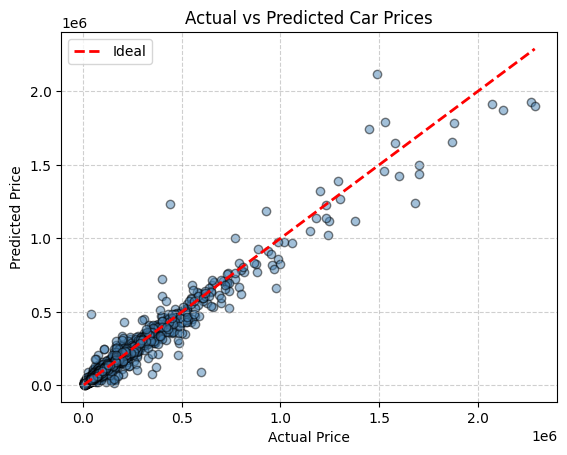

In [ ]:
# actual vs predicted
plt.scatter(y_test, test_pred, alpha=0.5, color="steelblue", edgecolors="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--", linewidth=2, label="Ideal")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

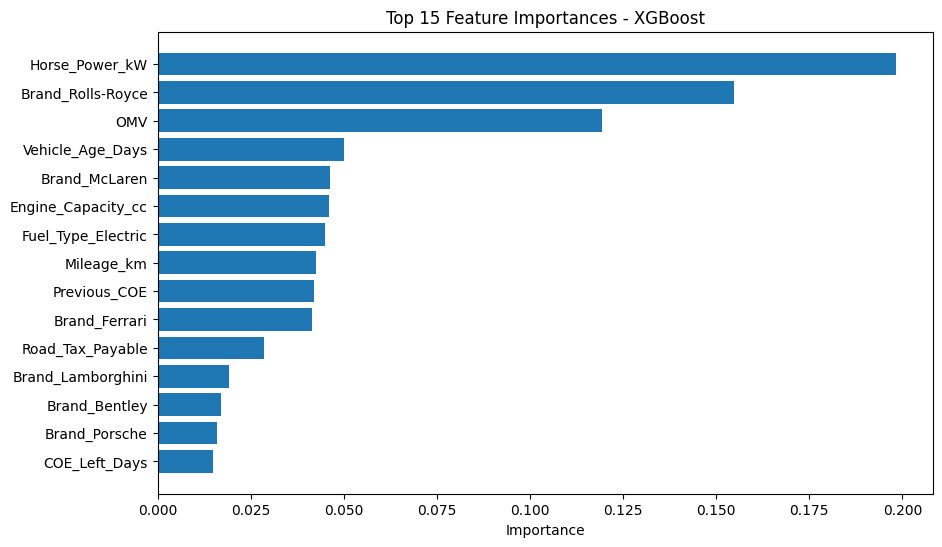

In [ ]:
# top 15 important features
# Extract the trained random forest model
xgb_model = xgb.named_steps['regressor']

# Get preprocessor and feature names
preprocessor = xgb.named_steps['preprocessor']

# Get column names after one-hot encoding
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(preprocessor.transformers_[1][2])
feature_names = np.concatenate([num_features, cat_features])

# Get feature importances
importances = xgb_model.feature_importances_

# Create dataframe
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['Feature'][:15][::-1], feat_importance_df['Importance'][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()

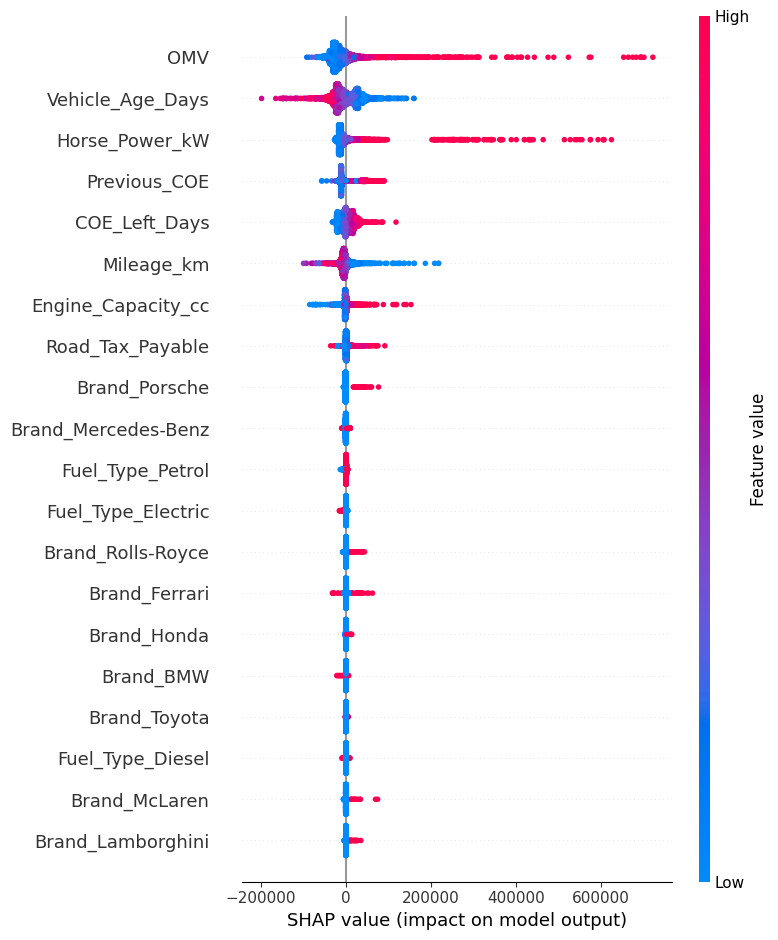

In [ ]:
# Initialize explainer (use only transformed data)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed)

# Create SHAP summary plot
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)

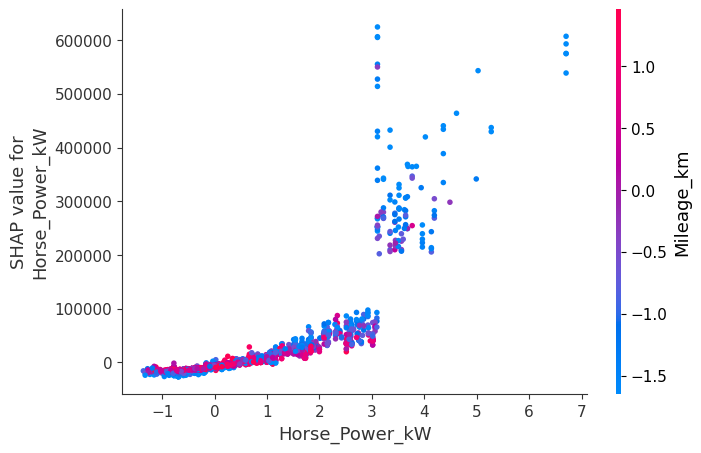

In [ ]:
# Plot dependence of top feature
top_feature = feat_importance_df.iloc[0]['Feature']
shap.dependence_plot(top_feature, shap_values, X_test_transformed, feature_names=feature_names)